In [1]:
# Cell 0: 모듈 import를 위한 경로 설정
import os, sys
sys.path.append(os.path.abspath(".."))  # shared, models 디렉토리 접근 가능하도록 경로 추가


In [2]:
# Cell 1: 환경 확인
import torch

print(f"✅ PyTorch version: {torch.__version__}")
print(f"🚀 GPU available: {torch.cuda.is_available()}")

if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print(f"🧠 GPU name: {torch.cuda.get_device_name(0)}")
    
    total_memory = torch.cuda.get_device_properties(device).total_memory / 1024**3  # GiB
    reserved_memory = torch.cuda.memory_reserved(device) / 1024**3  # GiB
    allocated_memory = torch.cuda.memory_allocated(device) / 1024**3  # GiB
    free_memory = reserved_memory - allocated_memory  # GiB

    print(f"💾 Total memory: {total_memory:.2f} GiB")
    print(f"📦 Reserved memory: {reserved_memory:.2f} GiB")
    print(f"📈 Allocated memory: {allocated_memory:.2f} GiB")
    print(f"🟢 Free memory in reserved: {free_memory:.2f} GiB")


✅ PyTorch version: 2.6.0+cu124
🚀 GPU available: True
🧠 GPU name: Quadro RTX 5000
💾 Total memory: 15.73 GiB
📦 Reserved memory: 0.00 GiB
📈 Allocated memory: 0.00 GiB
🟢 Free memory in reserved: 0.00 GiB


In [3]:
# Cell 2: 데이터셋 로딩
from torch.utils.data import DataLoader
from shared.data_loader import HDF5Dataset
import os

input_dir = "/caefs/data/IllustrisTNG/subcube/input"
output_dir = "/caefs/data/IllustrisTNG/subcube/output"

input_files = sorted([os.path.join(input_dir, f) for f in os.listdir(input_dir) if f.endswith(".h5")])
output_files = sorted([os.path.join(output_dir, f) for f in os.listdir(output_dir) if f.endswith(".h5")])

dataset = HDF5Dataset(input_files, output_files)
loader = DataLoader(dataset, batch_size=2, shuffle=True)

x, y = next(iter(loader))
print(f"✅ Sample loaded: input shape = {x.shape}, output shape = {y.shape}")


2025-07-30 20:41:42,508 | INFO | data_loader | 🔍 Initializing dataset with 12 file pairs.
2025-07-30 20:41:42,529 | INFO | data_loader | 📦 Total samples across all files: 110592


✅ Sample loaded: input shape = torch.Size([2, 1, 60, 60, 60]), output shape = torch.Size([2, 1, 60, 60, 60])


In [4]:
# Cell 3: ViT 초기화 for scalar regression from full 3D volume
from models.vit.model import ViT3D
import torch

# 입력 크기와 동일하게 설정
input_shape = (60, 60, 60)  # (D, H, W)
patch_spatial = 10         # → 60 / 10 = 6 패치
patch_depth = 10           # → 60 / 10 = 6 패치

# 디바이스 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 모델 선택: "full" or "simple"
model_name = "full"


model = ViT3D(
    image_size=input_shape[1],
    frames=input_shape[0],
    image_patch_size=patch_spatial,
    frame_patch_size=patch_depth,
    dim=256,
    depth=6,
    heads=8,
    mlp_dim=512,
    in_channels=1,
    out_channels=1
).to(device)

model.train()

# Dummy input 확인
x_dummy = torch.randn(2, 1, *input_shape).to(device)  # [B, C, D, H, W]
y_dummy = model(x_dummy)

print(f"✅ ViT model ({model_name}) loaded and set to training mode.")
print(f"📐 Dummy input: {x_dummy.shape} → Prediction shape: {y_dummy.shape}")


✅ ViT model (full) loaded and set to training mode.
📐 Dummy input: torch.Size([2, 1, 60, 60, 60]) → Prediction shape: torch.Size([2, 1, 60, 60, 60])


In [5]:
from torchinfo import summary

summary(model, input_size=(2, 1, 60, 60, 60), col_names=["input_size", "output_size", "num_params", "kernel_size"])

Layer (type:depth-idx)                             Input Shape               Output Shape              Param #                   Kernel Shape
ViT3D                                              [2, 1, 60, 60, 60]        [2, 1, 60, 60, 60]        55,296                    --
├─Sequential: 1-1                                  [2, 1, 60, 60, 60]        [2, 216, 256]             --                        --
│    └─Rearrange: 2-1                              [2, 1, 60, 60, 60]        [2, 216, 1000]            --                        --
│    └─LayerNorm: 2-2                              [2, 216, 1000]            [2, 216, 1000]            2,000                     --
│    └─Linear: 2-3                                 [2, 216, 1000]            [2, 216, 256]             256,256                   --
│    └─LayerNorm: 2-4                              [2, 216, 256]             [2, 216, 256]             512                       --
├─Dropout: 1-2                                     [2, 216, 256]  

In [6]:
from models.vit.model import ViT3D
from torch.utils.data import DataLoader

def test_batch_size(batch_size):
    try:
        loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

        # ⚠️ ViT3D의 patch 크기 → 10이면 60 % 10 == 0
        model = ViT3D(
            image_size=60,           # H/W
            frames=60,               # D
            image_patch_size=10,
            frame_patch_size=10,
            dim=256,
            depth=6,
            heads=8,
            mlp_dim=512,
            in_channels=1,
            out_channels=1
        ).cuda()

        for x, y in loader:
            x, y = x.cuda(), y.cuda()
            pred = model(x)
            print(f"✅ Success with batch_size={batch_size}, pred.shape={pred.shape}")
            break
    except RuntimeError as e:
        print(f"❌ Failed with batch_size={batch_size}: {str(e).splitlines()[0]}")

for bs in [32, 16, 8, 4, 2, 1]:
    test_batch_size(bs)


✅ Success with batch_size=32, pred.shape=torch.Size([32, 1, 60, 60, 60])
✅ Success with batch_size=16, pred.shape=torch.Size([16, 1, 60, 60, 60])
✅ Success with batch_size=8, pred.shape=torch.Size([8, 1, 60, 60, 60])
✅ Success with batch_size=4, pred.shape=torch.Size([4, 1, 60, 60, 60])
✅ Success with batch_size=2, pred.shape=torch.Size([2, 1, 60, 60, 60])
✅ Success with batch_size=1, pred.shape=torch.Size([1, 1, 60, 60, 60])


In [7]:
# Cell 4: 손실 함수 테스트
from shared.losses import mse_loss

loss_val = mse_loss(x.to(device), y.to(device))
print(f"✅ MSE Loss on batch: {loss_val.item():.4f}")


✅ MSE Loss on batch: 89.6607


In [8]:
# Cell 5: Optimizer 및 스케줄러 설정
import torch.optim as optim

optimizer = optim.Adam(model.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)
print("✅ Optimizer and LR scheduler initialized.")


✅ Optimizer and LR scheduler initialized.


In [10]:
# Cell 6: 빠른 학습 루프 (1 epoch, 일부 batch만)
from tqdm import tqdm

model.train()
n_batch = 10  # 테스트용으로 10개 배치만 학습

for epoch in range(3):
    total_loss = 0.0
    for i, (inputs, targets) in enumerate(tqdm(loader, desc=f"Epoch {epoch+1}")):
        if i >= n_batch:
            break
        inputs, targets = inputs.to(device), targets.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)  # outputs.shape: [B, 1]
        loss = mse_loss(outputs, targets)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    scheduler.step()
    print(f"📉 Epoch {epoch+1} (partial) Loss: {total_loss / n_batch:.4f} | LR: {scheduler.get_last_lr()[0]:.2e}")



Epoch 1:   0%|          | 10/55296 [00:02<3:47:16,  4.05it/s]


📉 Epoch 1 (partial) Loss: 1.1810 | LR: 9.76e-05


Epoch 2:   0%|          | 10/55296 [00:02<3:15:58,  4.70it/s]


📉 Epoch 2 (partial) Loss: 0.6831 | LR: 9.05e-05


Epoch 3:   0%|          | 10/55296 [00:02<3:24:10,  4.51it/s]

📉 Epoch 3 (partial) Loss: 0.3216 | LR: 7.94e-05


In [12]:
import matplotlib.pyplot as plt

model.eval()
with torch.no_grad():
    input_sample, target_sample = next(iter(loader))
    input_sample, target_sample = input_sample.to(device), target_sample.to(device)
    pred_sample = model(input_sample)




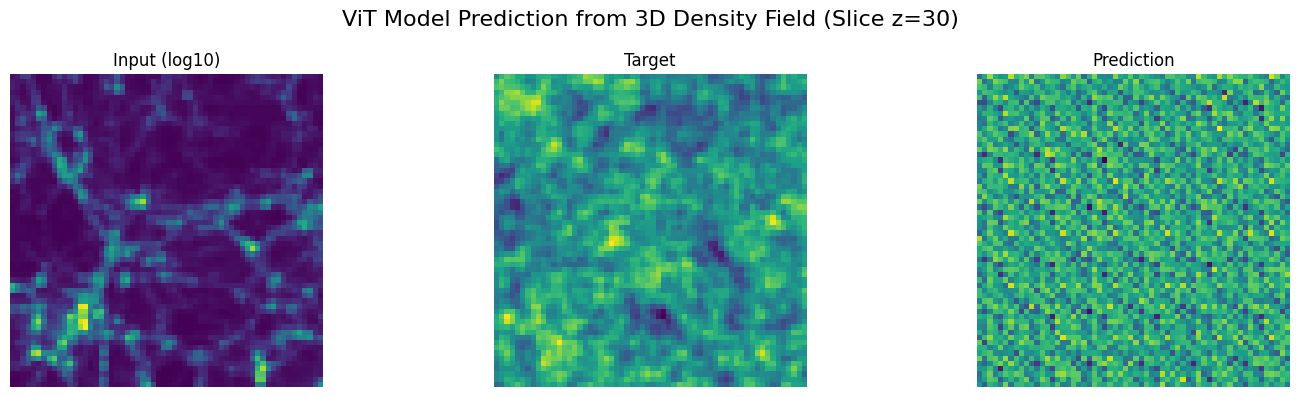

In [14]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# 예시: input = [B, 1, D, H, W] 중에서 B=0, D=30인 2D 슬라이스
input_slice = inputs[0, 0, 30].detach().cpu().numpy()
target_slice = targets[0, 0, 30].detach().cpu().numpy()
pred_slice = outputs[0, 0, 30].detach().cpu().numpy()

# ✅ log-transform (0을 피하기 위해 log(1 + x) 사용)
input_log = np.log10(1 + input_slice)

# 📊 시각화
fig, axs = plt.subplots(1, 3, figsize=(15, 4))

axs[0].imshow(input_log, cmap='viridis')
axs[0].set_title('Input (log10)')

axs[1].imshow(target_slice, cmap='viridis')
axs[1].set_title('Target')

axs[2].imshow(pred_slice, cmap='viridis')
axs[2].set_title('Prediction')

for ax in axs:
    ax.axis('off')

plt.suptitle('ViT Model Prediction from 3D Density Field (Slice z=30)', fontsize=16)  # ✅ 전체 제목 추가
plt.tight_layout()
plt.show()


In [1]:
from graphviz import Digraph

g = Digraph(comment="ViT3D Module-level Schematic", format="png")
g.attr(rankdir="LR")  # 왼쪽에서 오른쪽 흐름

# Input / patch embedding / projection
g.node("In", "Input [B,1,60³]")
g.node("PatchEmbed", "Patch Embedding + Linear Projection\n-> [B, N_patches=216, D=256]")
g.edge("In", "PatchEmbed")

# Optional LayerNorm before/after projection
g.node("PreLN", "LayerNorm")
g.edge("PatchEmbed", "PreLN")

# Dropout
g.node("Dropout", "Dropout")
g.edge("PreLN", "Dropout")

# Transformer blocks with residuals (showing N times)
for i in range(1, 7):  # assuming 6 transformer layers as in summary
    attn = f"Attn{i}"
    mlp = f"MLP{i}"
    ln1 = f"LN1_{i}"
    ln2 = f"LN2_{i}"
    res1 = f"Res1_{i}"
    res2 = f"Res2_{i}"

    # LayerNorm -> Self-Attention -> residual
    g.node(ln1, "LayerNorm")
    g.node(attn, "Multi-Head Self-Attention")
    g.node(res1, "Residual Add")
    g.edge("Dropout" if i == 1 else res2, ln1)
    g.edge(ln1, attn)
    g.edge(attn, res1)
    g.edge(res1, res1, style="invis")  # to keep layout stable

    # LayerNorm -> MLP -> residual
    g.node(ln2, "LayerNorm")
    g.node(mlp, "MLP (FFN)")
    g.node(res2, "Residual Add")
    g.edge(res1, ln2)
    g.edge(ln2, mlp)
    g.edge(mlp, res2)

# Final projection back
g.node("PostLN", "LayerNorm")
g.node("Proj", "Linear Head (to token dim 1000)")
g.edge(res2, "PostLN")
g.edge("PostLN", "Proj")

# Output (could be reshaped back to 3D)
g.node("Out", "Output [B,1,60³] (via reshape/regression head)")
g.edge("Proj", "Out")

# Render
g.render("vit3d_module_schematic", cleanup=True)


'vit3d_module_schematic.png'

In [2]:
from graphviz import Digraph

g = Digraph(comment="Compact ViT3D Schematic", format="png")
g.attr(rankdir="LR", fontsize="12")

# Nodes
g.node("Input", "Input 3D Volume\n[B,1,60³]")
g.node("PatchProj", "Patch Embedding\n+ Positional Encoding\n→ [B, 216, 256]")
g.node("Transformer", "Transformer Block ×6\n(Pre-LN, Self-Attn + Residual\n→ MLP + Residual)")
g.node("FinalNorm", "LayerNorm")
g.node("Head", "Linear Projection\n(to token dim / regression space)")
g.node("Reshape", "Reshape / Regression\n→ Output 3D Volume\n[B,1,60³]")
g.node("Output", "Reconstructed Overdensity")

# Edges
g.edge("Input", "PatchProj")
g.edge("PatchProj", "Transformer")
g.edge("Transformer", "FinalNorm")
g.edge("FinalNorm", "Head")
g.edge("Head", "Reshape")
g.edge("Reshape", "Output")

# Optional annotation: residuals inside transformer block indicated in label already
g.render("vit3d_compact_schematic", cleanup=True)


'vit3d_compact_schematic.png'